In [1]:
%matplotlib inline
import sys
sys.path.append('/home/miguel/codes/nthRootsOfUnity/src/')
sys.path.append('/opt/petsc/3.10.5-impi-devtoolset-7/complex/lib/petsc/bin/')

In [2]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

np.set_printoptions(linewidth=130)

In [3]:
from case import *
from PetscBinaryIO import PetscBinaryIO
from fsmpfuncs import weight

Ux/Utip =  0.41
AoA = 67.70637084030591
Re =  700.0
dt =  0.001799999999999996


In [5]:
d = np.loadtxt('2-Spectrum/v_j006_n013_spectrum.txt', dtype=complex)
j, nP, i = d[:,0].real.astype(int), d[0,1].real.astype(int), d[:,2].real.astype(int)
λ, e = np.log(d[:,3])/dt, d[:,4].real

In [6]:
R, iR = weight(dx, dy)

H = (y[-1]-y[0])

y = np.concatenate([ y[:1], np.concatenate([y[1:] + k*H for k in range(nP)])])
dy = np.diff(y)
yp = 0.5*(y[1:] + y[:-1])
dyp = np.diff(yp)
yu = yp
yv = y[:-1]

n1 = n
n = len(y)-1
pshape = (n, m)
ushape = (n, m-1)
vshape = (n, m)
                    
xi = np.concatenate([xi for k in range(nP)])
eta = np.concatenate([eta + k*H for k in range(nP)])
ds = np.concatenate([ds for k in range(nP)])
l1 = l
l = xi.size

In [10]:
modes = [138, 0]

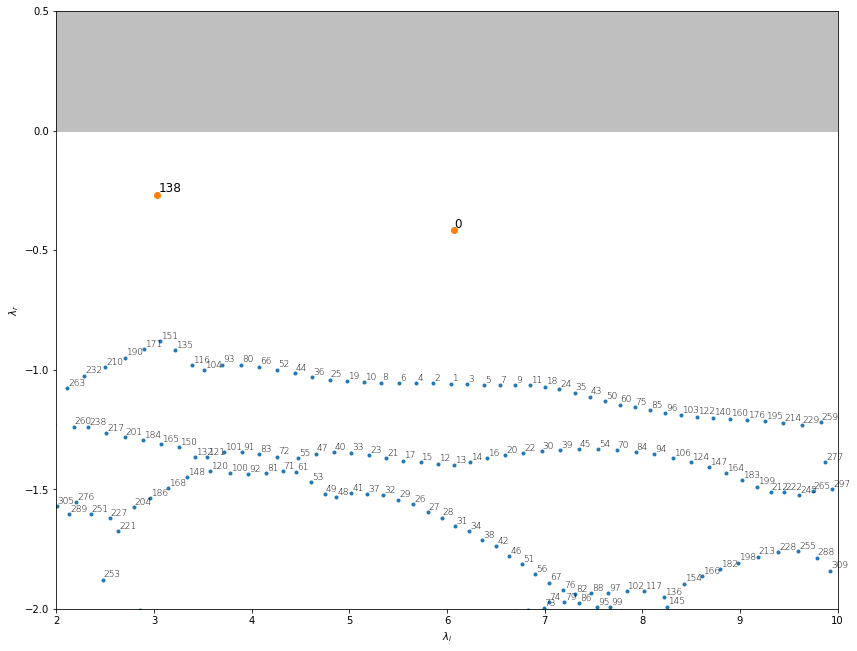

In [11]:
plt.figure(figsize=(14,11))
xmin, xmax, ymin, ymax = 2, 10, -2, 0.5
plt.plot(λ.imag, λ.real, '.')
plt.plot(λ[modes].imag, λ[modes].real, 'o')

for k, ik in enumerate(i):
    λi, λr = λ[ik].imag, λ[ik].real
    if xmin<=λi<=xmax and ymin<=λr<=ymax:
        plt.text(λ[ik].imag+0.01, λ[ik].real+0.01, '%d'%ik, weight='normal' if k in modes else 'light',
                 va='baseline', ha='left', fontsize=12 if k in modes else 9)

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.axhspan(0, ymax, xmin=0, xmax=10, color='0.75')
plt.xlabel(r'$\lambda_i$')
plt.ylabel(r'$\lambda_r$');

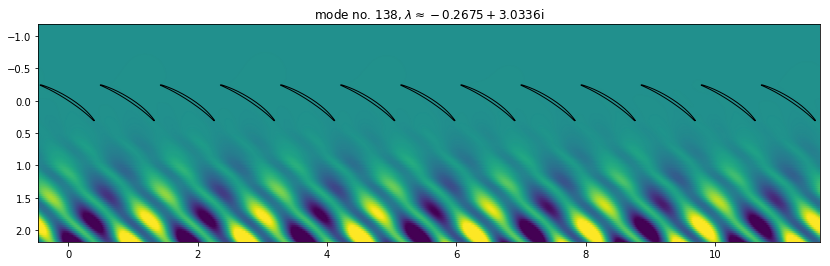

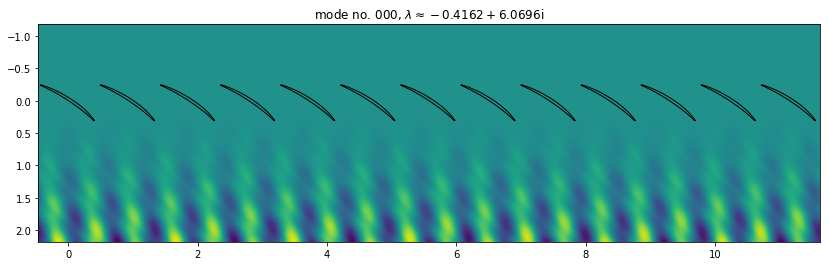

In [12]:
x0, x1 = -1, 2
y0, y1 = y[0], y[-1]

for mode in modes:
    jP = j[mode]
    ρk = np.exp(1j*jP*2*np.pi/nP)

    _vec = PetscBinaryIO().readBinaryFile('2-Spectrum/j%03d_n%03d_v_i%03d.dat'%(jP, nP, mode))[0]
    vec = np.empty(_vec.shape, dtype=np.complex)
    vec[:]=_vec[:]
    del _vec
    
    iRq = iR.dot(vec[:n1*(m-1) + n1*m])

    u = iRq[:n1*(m-1)].reshape((n1, m-1))
    v = iRq[n1*(m-1):].reshape((n1, m))
    ϕ = vec[n1*(m-1) + n1*m:n1*(m-1) + 2*n1*m].reshape((n1, m))
    
    u = np.vstack([ρk**(k-1)*u for k in range(nP)])
    v = np.vstack([ρk**(k-1)*v for k in range(nP)])
    ϕ = np.vstack([ρk**(k-1)*ϕ for k in range(nP)])
    
    plt.figure(figsize=(14,4))
    plt.pcolormesh(yu, xu, u.T.real, rasterized=True, shading='gouraud', vmin=0.05*np.min(u.real), vmax=0.05*np.max(u.real))
    plt.plot(np.asarray(np.split(eta, nP)).T, np.asarray(np.split(xi, nP)).T, 'k', lw=1);
    plt.axis('equal')
    plt.title(r'mode no. %03d, $λ \approx %.4f%+.4f\mathrm{i}$'%(mode, λ[mode].real, λ[mode].imag))
    plt.ylim(x1, x0)
    plt.xlim(y0, y1)